# Transition map analysis

In [1]:
import cospar as cs

In [2]:
cs.logging.print_version()
cs.settings.verbosity=2 #range: 0 (error),1 (warning),2 (info),3 (hint). 
cs.settings.set_figure_params(format='png',figsize=[4,3.5],dpi=75,fontsize=14,pointsize=3) 

Running cospar 0.1.9 (python 3.8.12) on 2021-11-10 18:28.


In [3]:
# Each dataset should have its folder to avoid conflicts.
cs.settings.data_path='data_cospar' 
cs.settings.figure_path='fig_cospar' 
cs.hf.set_up_folders()

Load an existing dataset. (If you have pre-processed data, you can load it with `cs.hf.read(file_name)`.)

In [4]:
adata_orig=cs.datasets.hematopoiesis_subsampled()

Generate a transition map

In [5]:
adata=cs.tmap.infer_Tmap_from_multitime_clones(adata_orig,clonal_time_points=['2','4'], 
                    later_time_point='6',smooth_array=[20,15,10,5],
          sparsity_threshold=0.1,intraclone_threshold=0.2,max_iter_N=10,epsilon_converge=0.01)

Trying to set attribute `.uns` of view, copying.


------Compute the full Similarity matrix if necessary------
------Infer transition map between initial time points and the later time one------
--------Current initial time point: 2--------
Step 1: Select time points
Number of multi-time clones post selection: 185
Step 2: Optimize the transition map recursively
Load pre-computed similarity matrix
Iteration 1, Use smooth_round=20
Iteration 2, Use smooth_round=15
Iteration 3, Use smooth_round=10
Iteration 4, Use smooth_round=5
Convergence (CoSpar, iter_N=4): corr(previous_T, current_T)=0.942
Iteration 5, Use smooth_round=5
Convergence (CoSpar, iter_N=5): corr(previous_T, current_T)=0.996
--------Current initial time point: 4--------
Step 1: Select time points
Number of multi-time clones post selection: 500
Step 2: Optimize the transition map recursively
Load pre-computed similarity matrix
Iteration 1, Use smooth_round=20
Iteration 2, Use smooth_round=15
Iteration 3, Use smooth_round=10
Iteration 4, Use smooth_round=5
Convergence (CoSpar,

### Key parameters

The analysis is done with the plotting module. There are some common parameters for the APIs in this module:

* **used_Tmap** (`str`; default: `transition_map`). It determines which transition map to use for analysis. Choices: {`transition_map`, `intraclone_transition_map`, `OT_transition_map`, `HighVar_transition_map`, `clonal_transition_map`}

* **selected_fates** (`list` of `str`). Selected clusters to aggregate differentiation dynamics and visualize fate bias etc.. It allows nested structure, e.g., selected_fates=[‘a’, [‘b’, ‘c’]] selects two clusters: cluster ‘a’ and the other that combines ‘b’ and ‘c’.

* **map_backward** (`bool`; default: True). We can analyze either the backward transitions, i.e., where these selected states or clusters came from (`map_backward=True`); or the forward transitions, i.e., where the selected states or clusters are going (`map_backward=False`).

* **selected_times** (`list`; default: all). List of time points to use. By default, all are used. 

* **method** (`str`; default: `norm-sum`). Method to aggregate the transition probability within a cluster. Choices: {`norm-sum`,`sum`}. `norm-sum` returns the probability that a fate cluster originates from an early state *i*; while `sum` gives the probability that an initial state *i* gives rise to a fate cluster.  

### Plotting transition profiles for single cells

First, check the forward transitions (i.e., future states) from the `'transition_map'`.

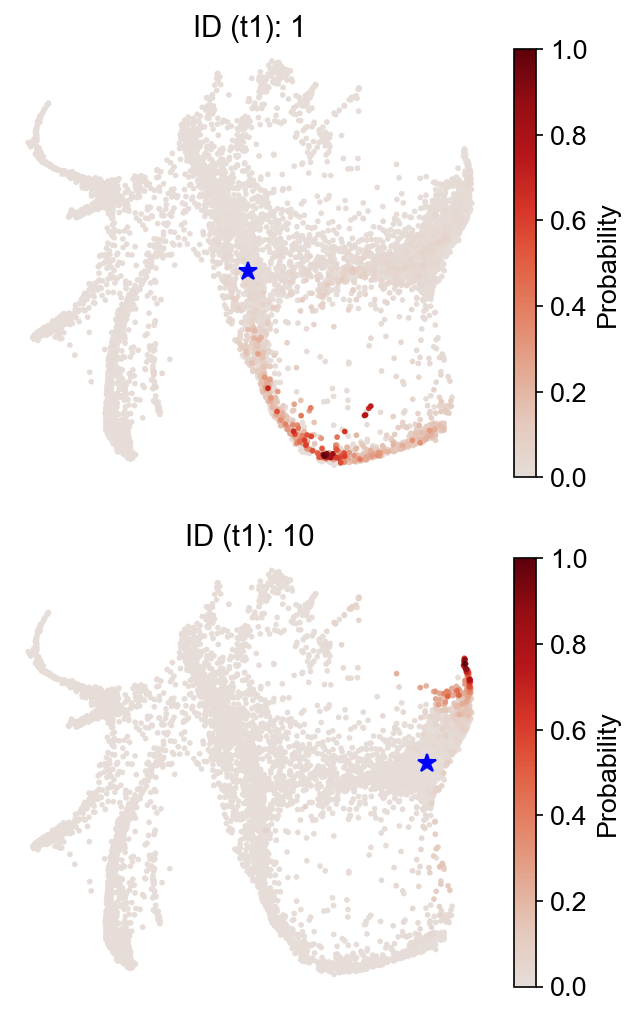

In [6]:
selected_state_id_list=[1,10] # This is a relative ID. Its mapping to the actual cell id depends on map_backward.

map_backward=False
cs.pl.single_cell_transition(adata,selected_state_id_list=selected_state_id_list,
                used_Tmap='transition_map',map_backward=map_backward)

Now, backward transitions (i.e., past states) from the same map.

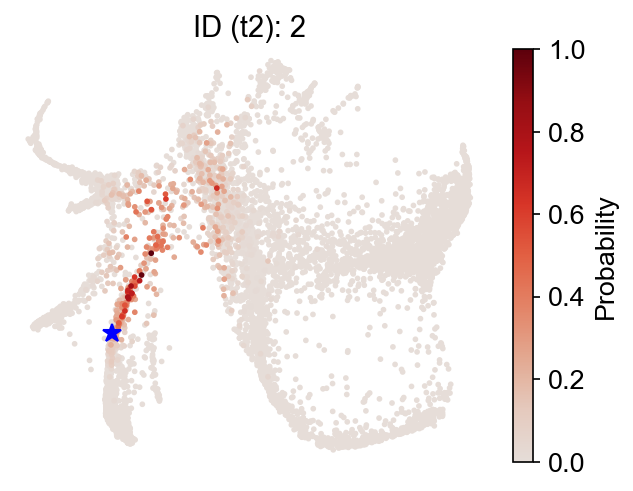

In [7]:
selected_state_id_list=[2]
map_backward=True
cs.pl.single_cell_transition(adata,selected_state_id_list=selected_state_id_list,
                    used_Tmap='transition_map',map_backward=map_backward)

Finally, switch to the `'intraclone_transition_map'`, and check the observed clonal transitions:

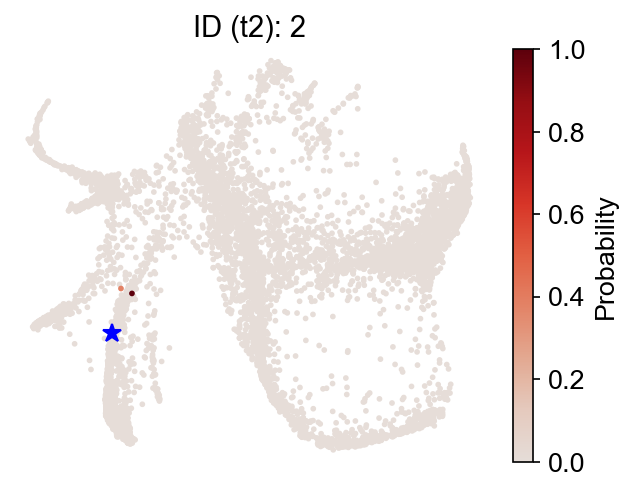

In [8]:
selected_state_id_list=[2] 
map_backward=True
cs.pl.single_cell_transition(adata,selected_state_id_list=selected_state_id_list,
                                    used_Tmap='intraclone_transition_map',map_backward=map_backward)

### Fate map

Inspect the backward transitions, and ask where the selected fate clusters come from.

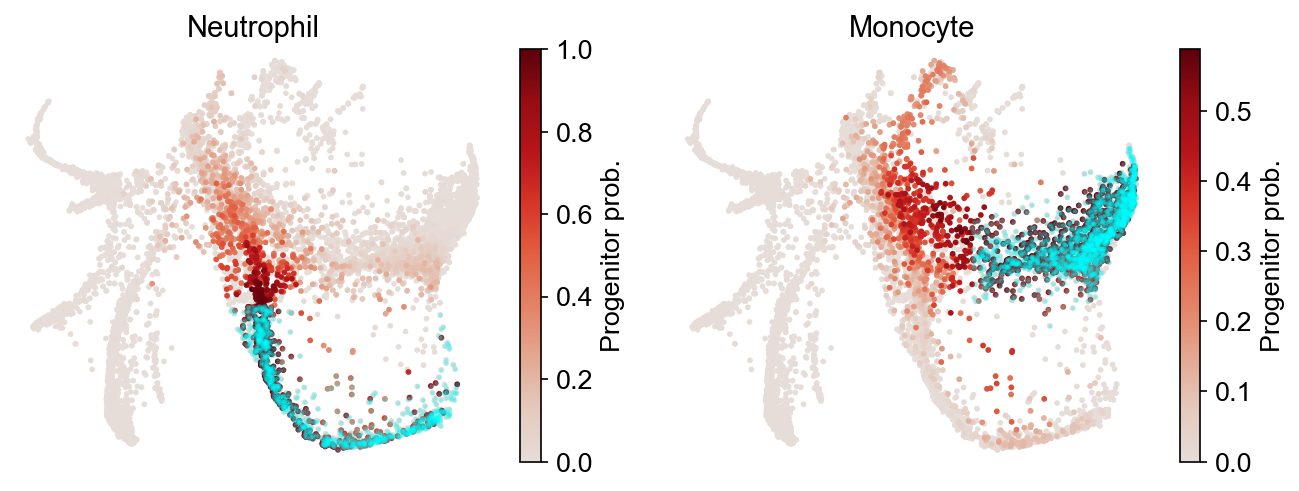

In [9]:
cs.pl.fate_map(adata,selected_fates=['Neutrophil','Monocyte'],
               used_Tmap='transition_map',map_backward=True,plot_target_state=True,horizontal=True)

The results are stored at `adata.obs[f'fate_map_{fate_name}']`, which can be used for a customized analysis.

In [10]:
adata.obs.keys()

Index(['time_info', 'state_info', 'n_counts', 'fate_map_Neutrophil',
       'fate_map_Monocyte'],
      dtype='object')

As an example of how to use this data, you can re-plot the fate map as follows:

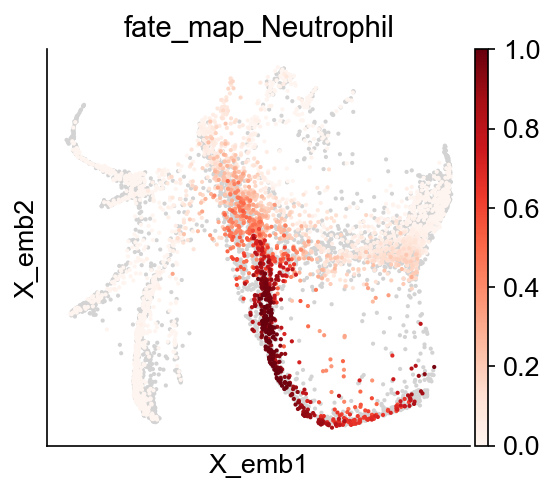

<Figure size 300x262.5 with 0 Axes>

In [11]:
cs.pl.embedding(adata,color='fate_map_Neutrophil')

### Fate potency

Count fate number directly (`fate_count=True`); otherwise, calculate the potencyusing entropy. The results are stored at `adata.obs['fate_potency']`.

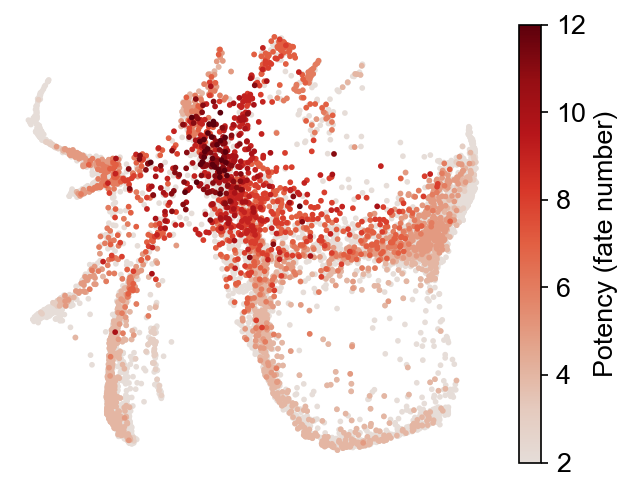

In [12]:
cs.pl.fate_potency(adata,used_Tmap='transition_map',
            map_backward=True,method='norm-sum',color_bar=True,fate_count=True)

### Fate bias

The fate bias of an initial state *i* is defined by the competition of fate probability towards two fate clusters A and B: 
    
* Bias_i=`P(i;A)/[P(i;A)+P(i;B)]`.
    
Only states with fate probabilities satisfying this criterion will be shown: 

* P(i; A)+P(i; B)>sum_fate_prob_thresh

The inferred fate bias is stored at `adata.obs[f'fate_bias_{fate_1}_{fate_2}']`.

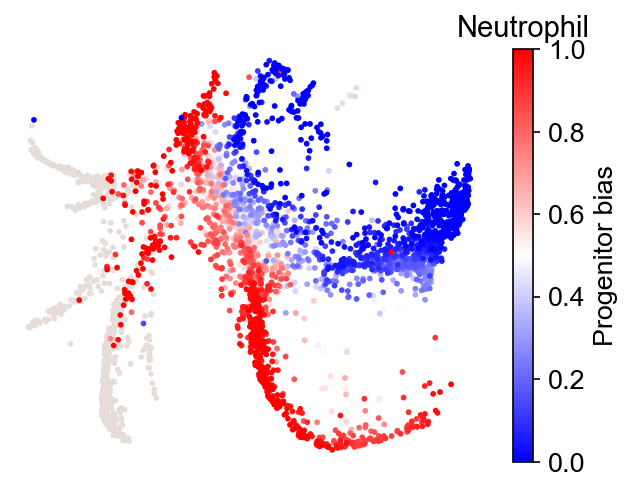

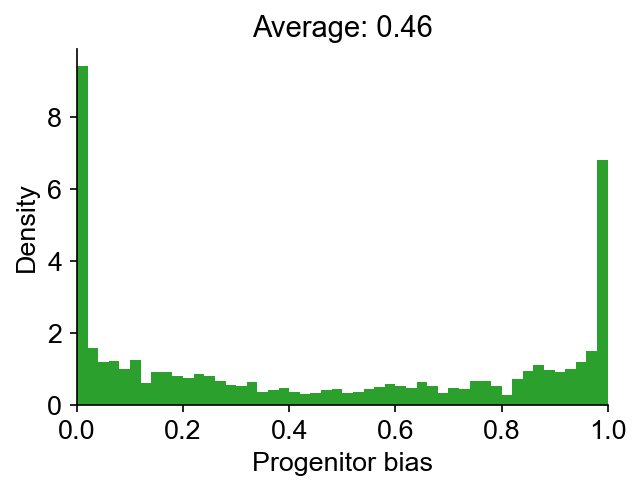

In [13]:
cs.pl.fate_bias(adata,selected_fates=['Neutrophil','Monocyte'],used_Tmap='transition_map',pseudo_count=0,
            plot_target_state=False,map_backward=True,sum_fate_prob_thresh=0.002,method='norm-sum')

We can also study fate bias in the Gata1+ states. First, prepare a sate mask:

In [14]:
x_emb=adata.obsm['X_emb'][:,0]
y_emb=adata.obsm['X_emb'][:,1]

index_2=cs.hf.above_the_line(adata.obsm['X_emb'],[100,500],[500,-1000])
index_5=cs.hf.above_the_line(adata.obsm['X_emb'],[0,-500],[1000,2])
final_mask= (~index_2) & ((index_5 | (x_emb<0))) #& index_3 & index_4 & index_5 #mask_1 &

Now, compute the fate bias. We can concatenate cluster 'Meg' and 'Erythroid' using a nested list. Same for concatenating 'Baso', 'Mast', and 'Eos'. 

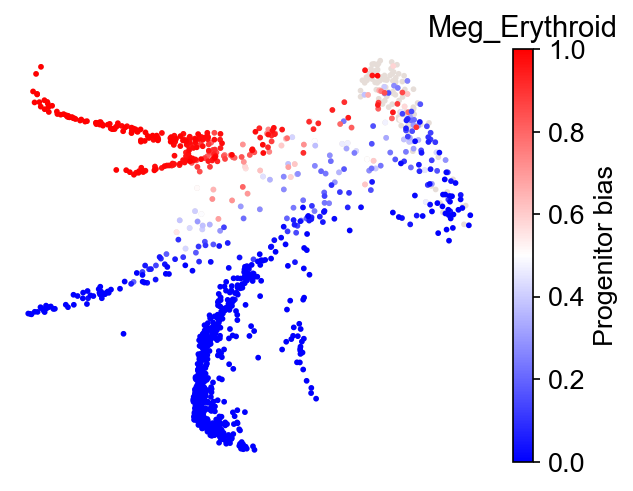

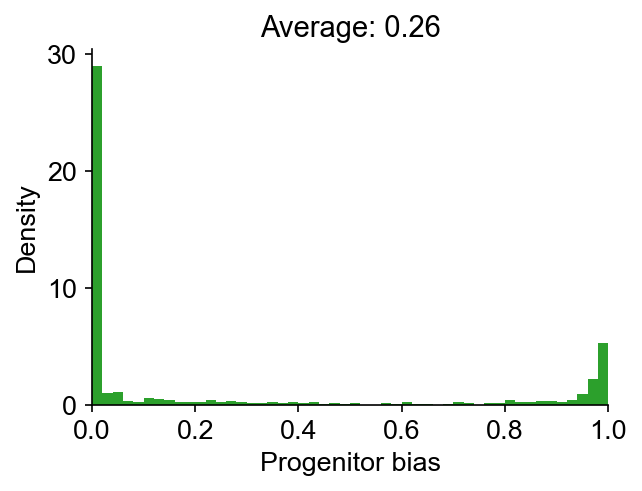

In [15]:
cs.pl.fate_bias(adata,selected_fates=[['Meg','Erythroid'],['Baso','Mast','Eos']],used_Tmap='transition_map',
        plot_target_state=False,mask=final_mask,map_backward=True,sum_fate_prob_thresh=0.01,method='norm-sum')

### Dynamic trajectory inference

We can infer the dynamic trajectory and ancestor population using the fate bias from binary fate competition. Here, fate bias is a scalar between (0,1) at each state. Selected ancestor population satisfies:

   * P(i;A) + P(i;B) > sum_fate_prob_thresh; 

   * Ancestor states {*i*} for A: Bias_i > bias_threshold_A

   * Ancestor states {*i*} for B: Bias_i < bias_threshold_B

They will be stored at `adata.obs['cell_group_A']`,  `adata.obs['cell_group_B']`, and `adata.obs[f'traj_{fate_name}']`. 

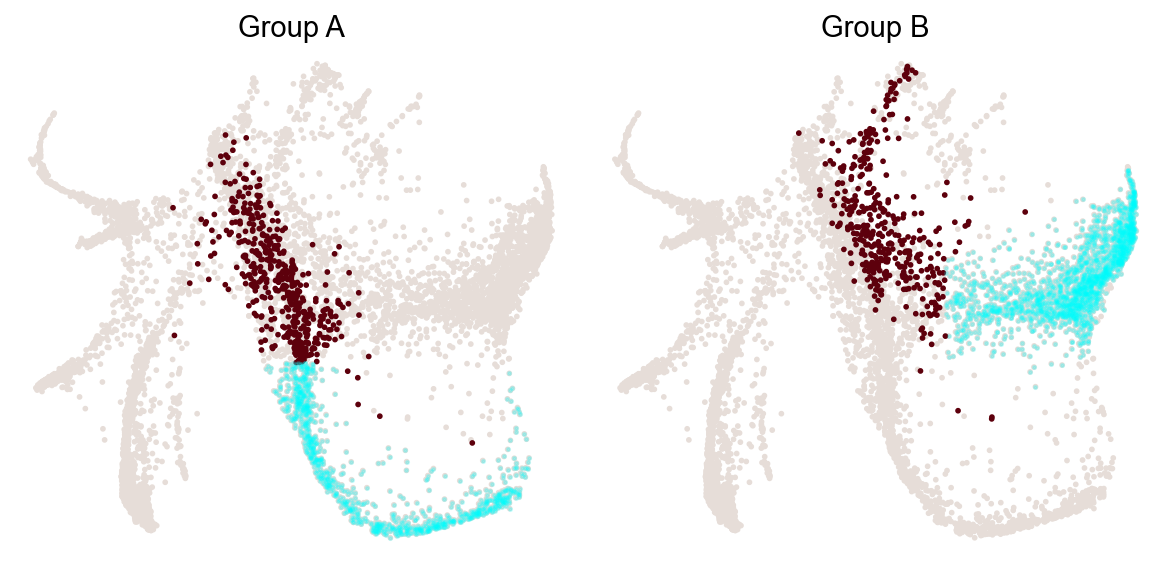

In [16]:
cs.pl.differentiation_trajectory(adata, selected_fates=['Neutrophil','Monocyte'], 
 used_Tmap='transition_map', map_backward=True, 
    bias_threshold_A=0.5,bias_threshold_B=0.5, sum_fate_prob_thresh=0.2, avoid_target_states=True)

We can visualize the trajectory directly

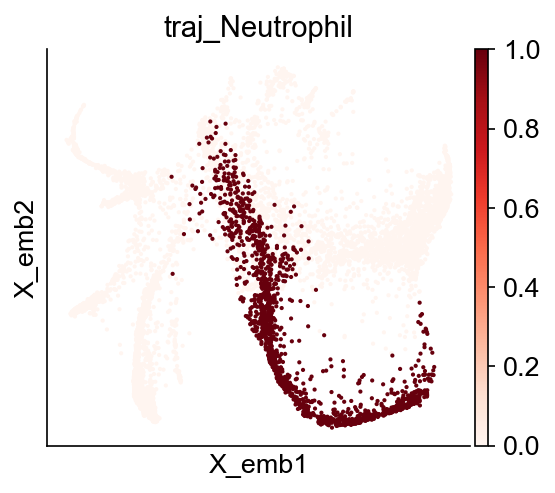

<Figure size 300x262.5 with 0 Axes>

In [17]:
fate_name='Neutrophil' #Monocyte
traj_name=f'traj_{fate_name}'
cs.pl.embedding(adata,color=traj_name)

### Differential genes for two ancestor groups

It would be interesting to see what genes are differentially expressed between these two ancestor populations, which might drive fate bifurcation. We provide a simple differentiation gene expression analysis that uses Wilcoxon rank-sum test to calculate P values, followed by Benjamini-Hochberg correction. You can always use your own method.

This function accepts populations defined in `adata.obs['cell_group_A']` and `adata.obs['cell_group_B']`, which have been generated in the previous step.

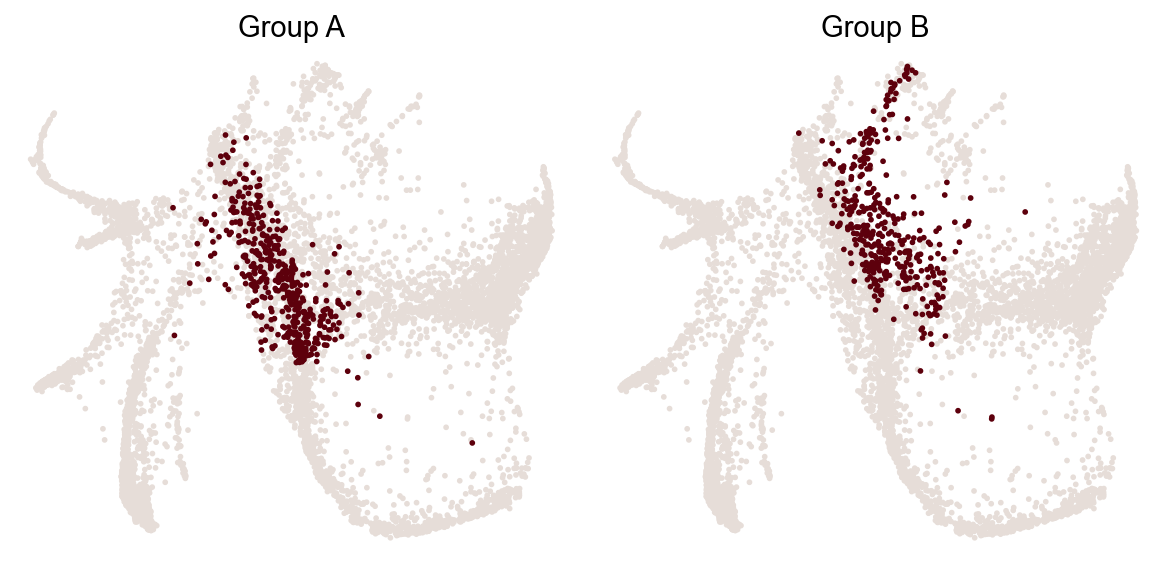

In [18]:
dge_gene_A, dge_gene_B=cs.pl.differential_genes(adata,plot_gene_N=0)

In [19]:
dge_gene_A

index   gene        Qvalue     mean_1     mean_2     ratio
0        2    Mpo  2.990318e-28   2.415750   8.792540 -1.519481
1        1  Elane  4.809145e-29   5.810114  17.454430 -1.438216
2        3  Gstm1  3.442987e-28   3.311963  10.061214 -1.359093
3       86  Gata2  3.905816e-04   0.224528   1.486434 -1.021853
4        0   Srgn  2.133473e-39  37.388157  75.211327 -0.989344
..     ...    ...           ...        ...        ...       ...
188    218  Ube2s  2.073772e-02   1.900290   2.287596 -0.180836
189    120    Pkm  2.156281e-03  17.192078  19.617094 -0.180531
190    160  Rpl12  7.945848e-03  31.622345  35.886330 -0.177226
191    198  Rplp0  1.516320e-02  13.676153  15.563156 -0.174504
192    246  Rps17  3.445027e-02  25.652222  28.897778 -0.165782

[193 rows x 6 columns]

Gene expression can be explored directly:

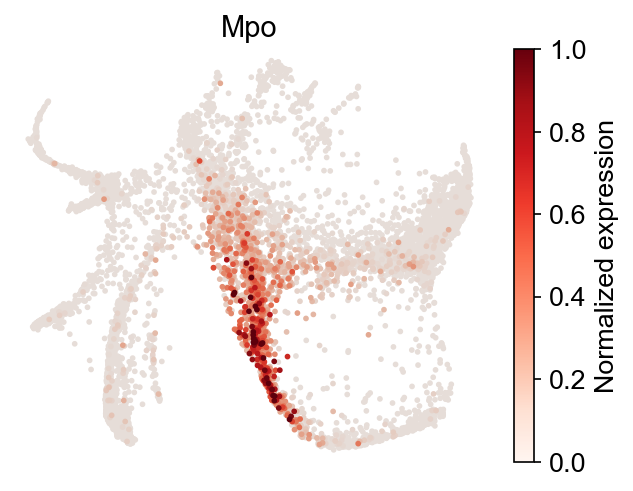

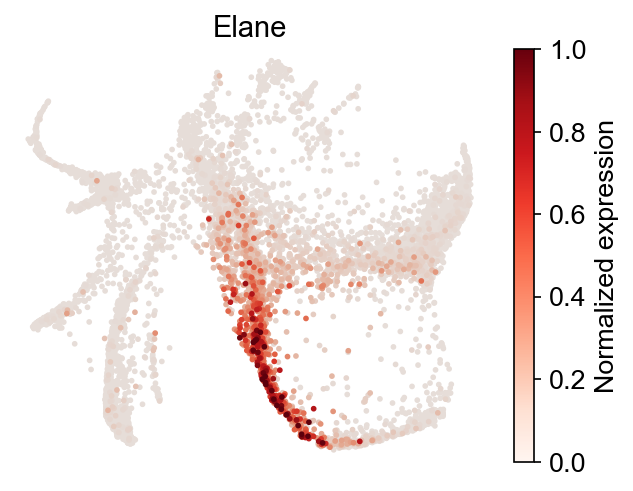

In [20]:
selected_genes=dge_gene_A['gene'][:2]
cs.pl.gene_expression_on_manifold(adata,selected_genes=selected_genes,color_bar=True,savefig=False)

You can visualize the gene expression differences using a heat map.

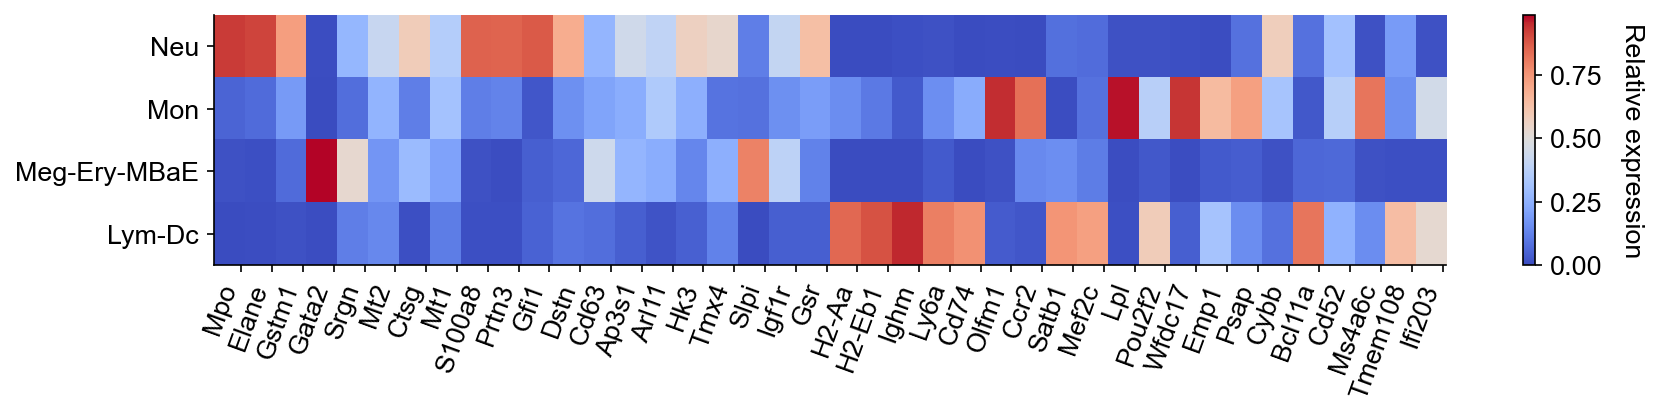

In [21]:
gene_list=list(dge_gene_A['gene'][:20])+list(dge_gene_B['gene'][:20]) #select the top 20 genes from both populations

selected_fates=['Neutrophil','Monocyte',['Baso','Eos','Erythroid','Mast','Meg'],['pDC','Ccr7_DC','Lymphoid']]
renames=['Neu','Mon','Meg-Ery-MBaE','Lym-Dc']

gene_expression_matrix=cs.pl.gene_expression_heat_map(adata,selected_genes=gene_list,selected_fates=selected_fates,
                            rename_fates=renames,fig_width=12)

You can define cell groups by yourself, and run the differential gene expression analysis.

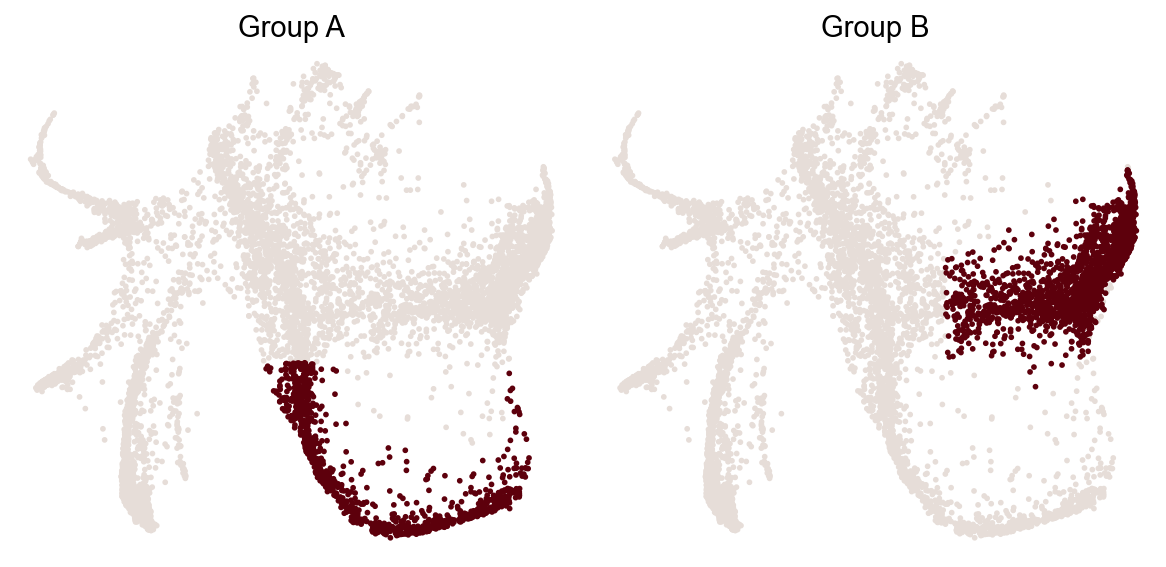

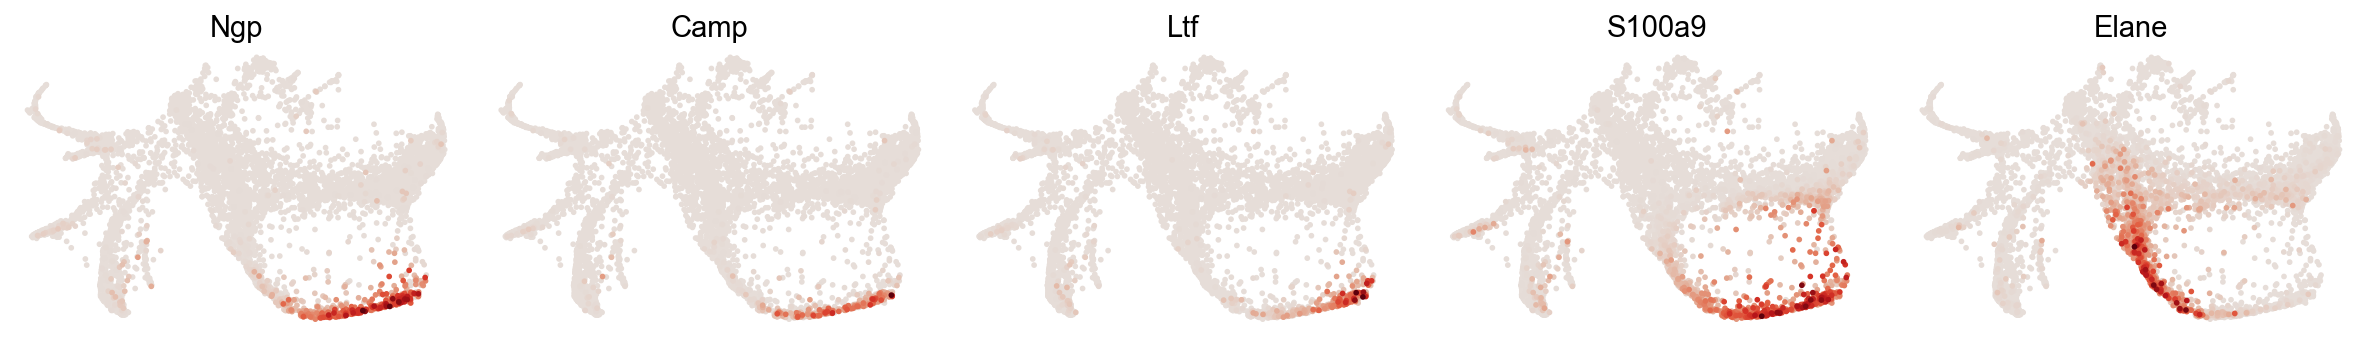

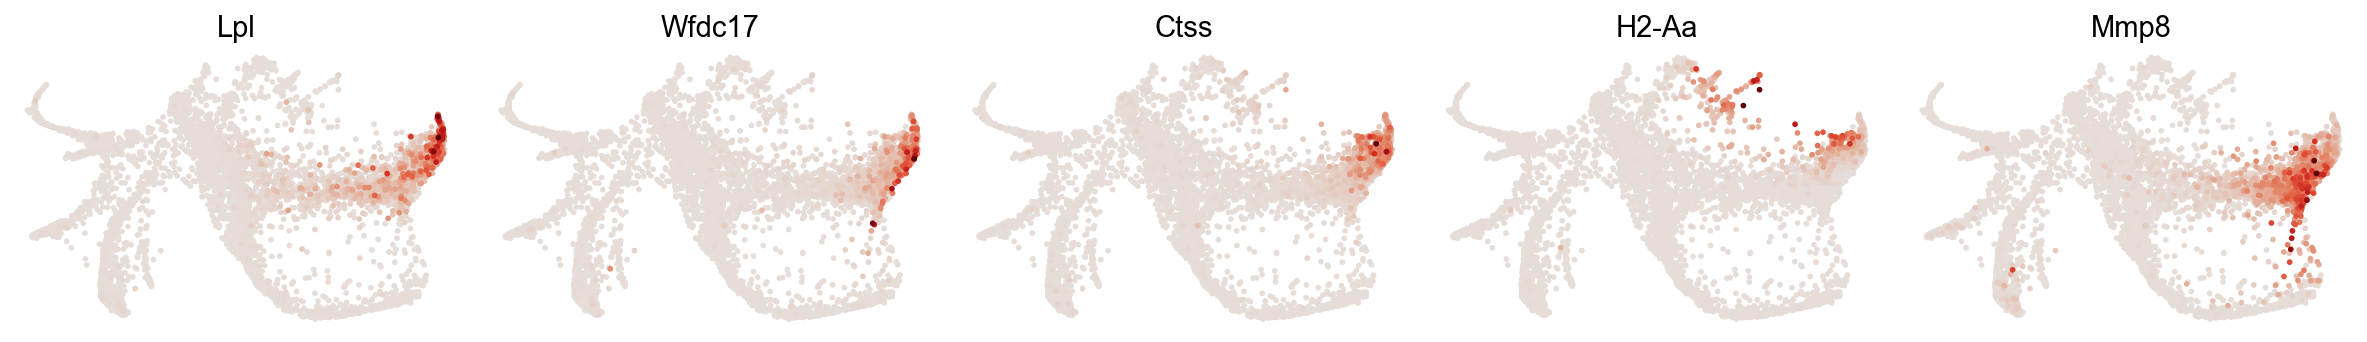

In [22]:
group_A_idx=adata.obs['state_info']=='Neutrophil'
group_B_idx=adata.obs['state_info']=='Monocyte'
dge_gene_A, dge_gene_B=cs.pl.differential_genes(adata,group_A_idx=group_A_idx,group_B_idx=group_B_idx,plot_gene_N=5)

### Gene expression dynamics

We can calculate the pseudotime along an inferred trajectory, and plot the gene expression along the pseudotime. This method requires that a trajectory has been inferred in previously steps.


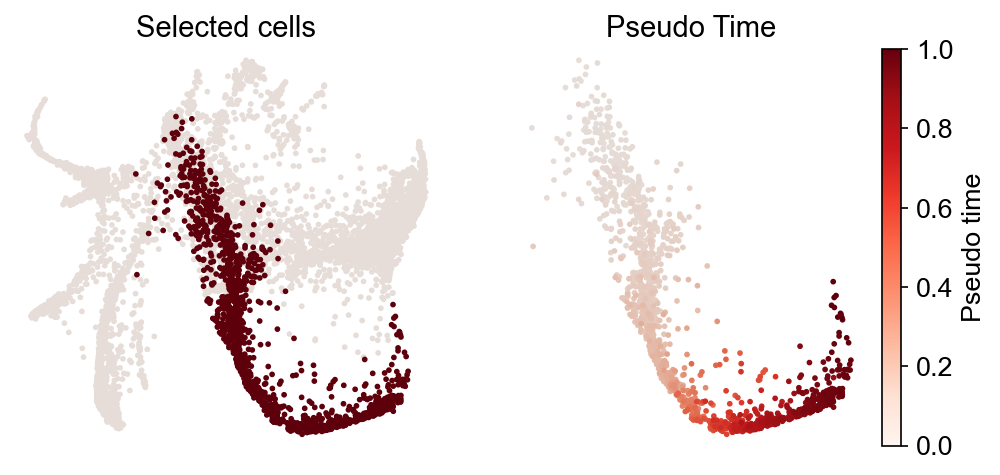

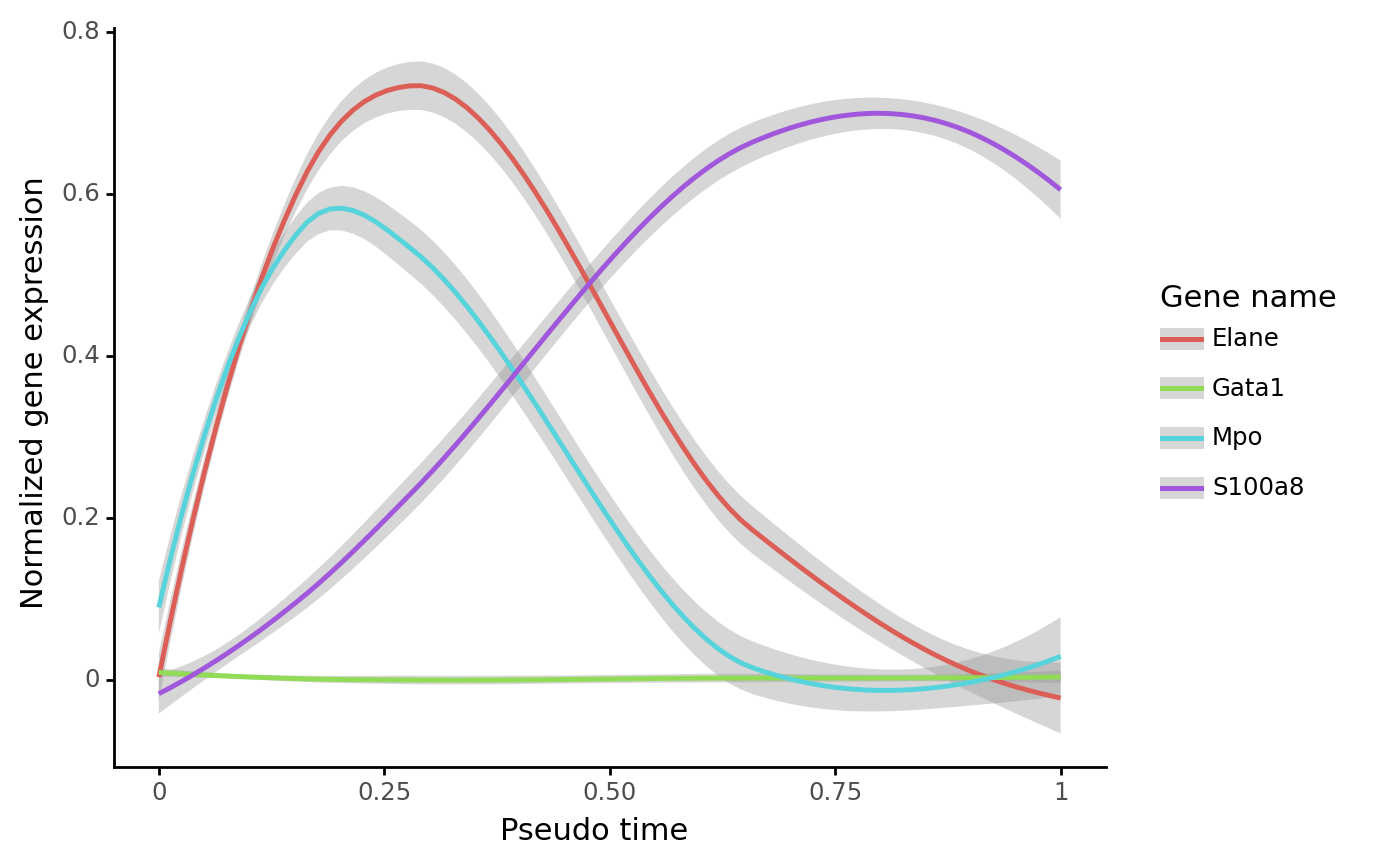

In [23]:
gene_name_list=['Gata1','Mpo', 'Elane', 'S100a8']
selected_fate='Neutrophil'
cs.pl.gene_expression_dynamics(adata,selected_fate,gene_name_list, traj_threshold=0.2,  
    invert_PseudoTime=False, compute_new=True, 
      gene_exp_percentile=99, n_neighbors=8, plot_raw_data=False)

You can perform pseudotime analysis with the selected cell states using any other existing packages for dynamic inference. 

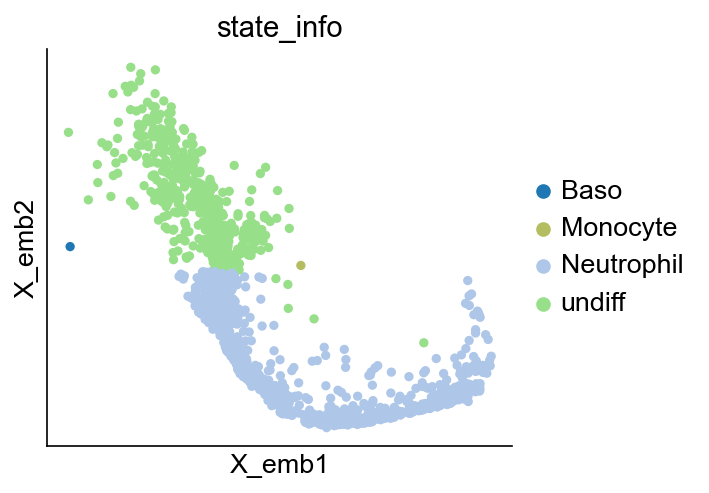

<Figure size 300x262.5 with 0 Axes>

In [24]:
fate_name='Neutrophil' #Monocyte
traj_name=f'traj_{fate_name}'
sub_adata=adata[adata.obs[traj_name]>0] # the sub_adata object is the adata with selected states, which can be used for pseudotime analysis
cs.pl.embedding(sub_adata,color='state_info')

### Fate coupling and hierarchy

The inferred transition map can be used to estimate differentiation coupling between different fate clusters. 

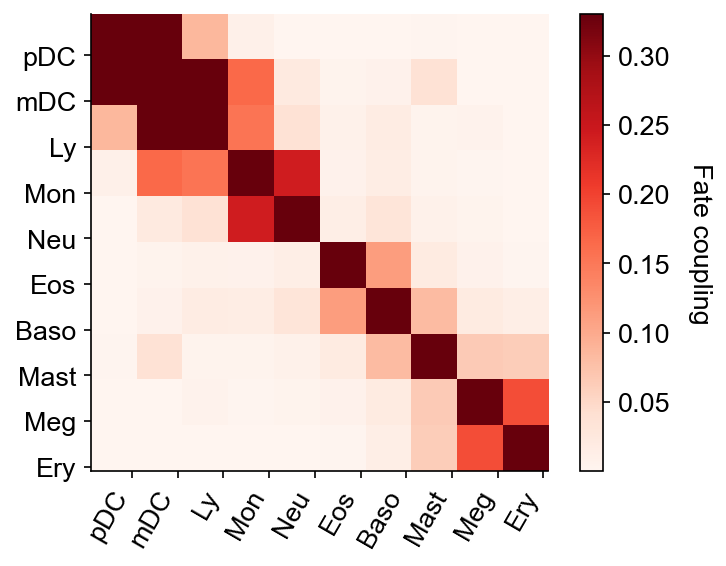

In [25]:
selected_fates=['Ccr7_DC','Mast','Meg','pDC','Eos','Lymphoid','Erythroid','Baso',  'Neutrophil', 'Monocyte']
celltype_names=['mDC',  'Mast', 'Meg', 'pDC', 'Eos', 'Ly', 'Ery', 'Baso', 'Neu', 'Mon']
coupling_matrix, fates=cs.pl.fate_coupling_from_Tmap(adata,selected_fates=selected_fates,used_Tmap='transition_map',
                        rename_fates=celltype_names)


We can also infer fate hierarchy from a transition map, based on the fate coupling matrix and using the neighbor-joining method.


            /-Baso
         /-|
      /-|   \-Eos
     |  |
   /-|   \-Mast
  |  |
  |  |   /-Ery
  |   \-|
--|      \-Meg
  |
  |      /-Mon
  |   /-|
  |  |   \-Neu
   \-|
     |      /-Ly
     |   /-|
      \-|   \-mDC
        |
         \-pDC


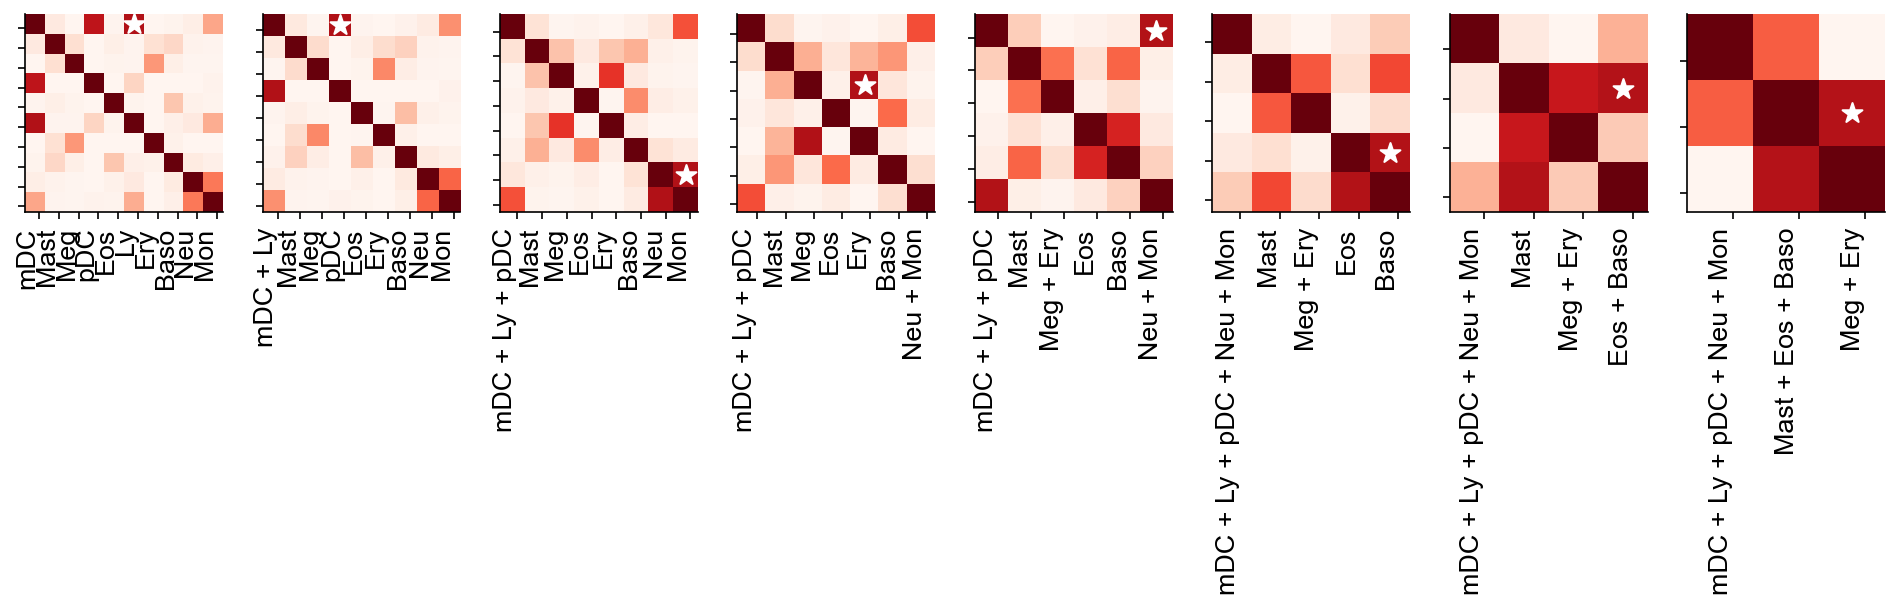

In [26]:
parent_map, node_mapping=cs.pl.fate_hierarchy_from_Tmap(adata,selected_fates=selected_fates,used_Tmap='transition_map',
                        rename_fates=celltype_names)

### Differential gene expression between two clusters

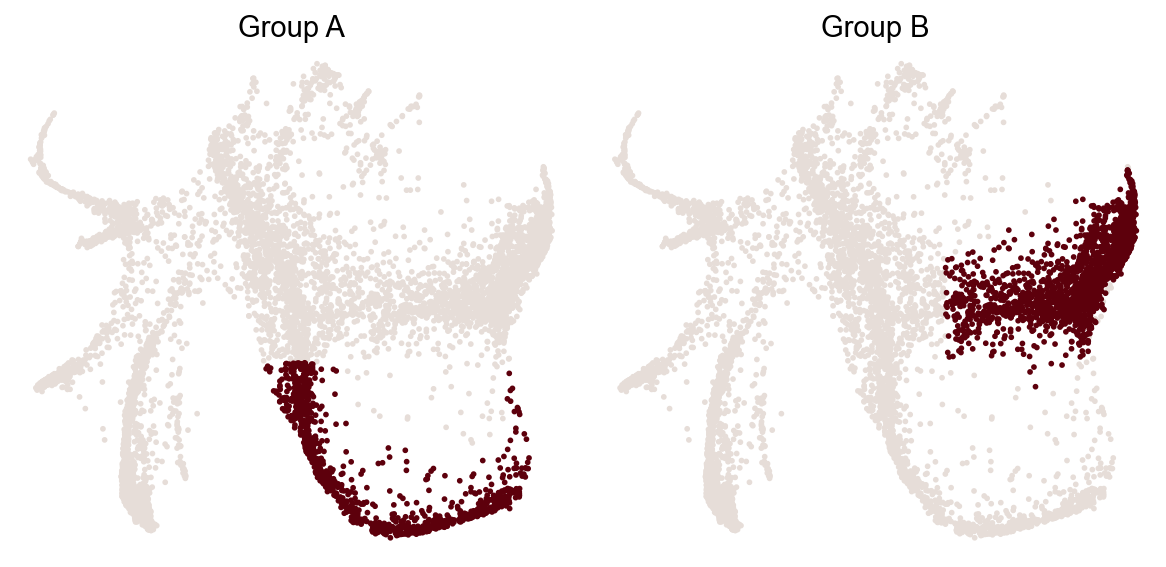

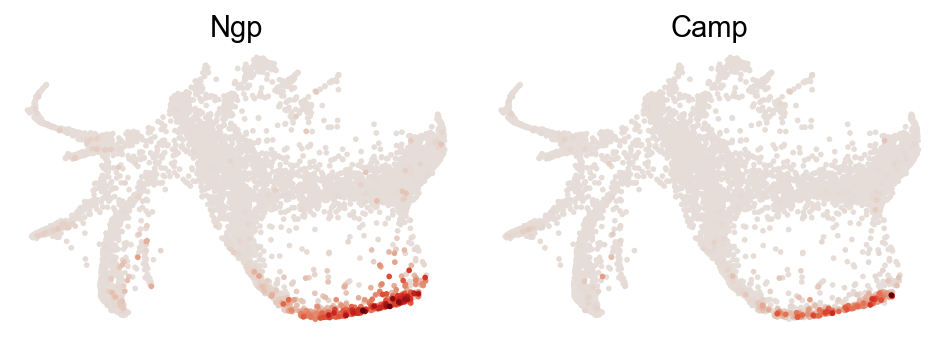

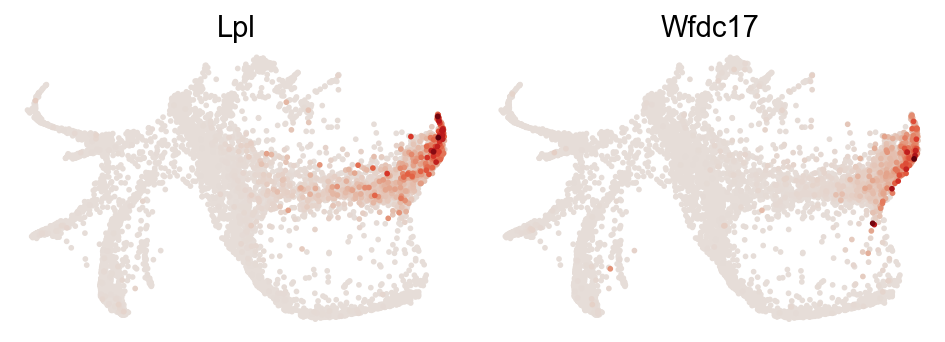

In [27]:
diff_gene_A,diff_gene_B=cs.pl.differential_genes_for_given_fates(adata,
            selected_fates=['Neutrophil','Monocyte'],plot_gene_N=2)

### Propagate a cluster in time

One way to define the dynamic trajectory is simply mapping a given fate cluster backward in time. The whole trajectory across multiple time points will be saved at `adata.obs[f'traj_{fate_name}']`. This method requires having multiple clonal time points, and a transition map between neighboring time points. 



First, use all clonal time points (the default), and infer a transition map between neighboring time points (by not setting `later_time_point`).

In [28]:
adata_5=cs.tmap.infer_Tmap_from_multitime_clones(adata_orig,smooth_array=[20,15,10,5],
          sparsity_threshold=0.2,intraclone_threshold=0.2,max_iter_N=10,epsilon_converge=0.01)

------Compute the full Similarity matrix if necessary------
----Infer transition map between neighboring time points-----
Step 1: Select time points
Number of multi-time clones post selection: 500
Step 2: Optimize the transition map recursively
Load pre-computed similarity matrix
Iteration 1, Use smooth_round=20
Iteration 2, Use smooth_round=15
Iteration 3, Use smooth_round=10
Iteration 4, Use smooth_round=5
Convergence (CoSpar, iter_N=4): corr(previous_T, current_T)=0.912
Iteration 5, Use smooth_round=5
Convergence (CoSpar, iter_N=5): corr(previous_T, current_T)=0.993
-----------Total used time: 18.88890290260315 s ------------


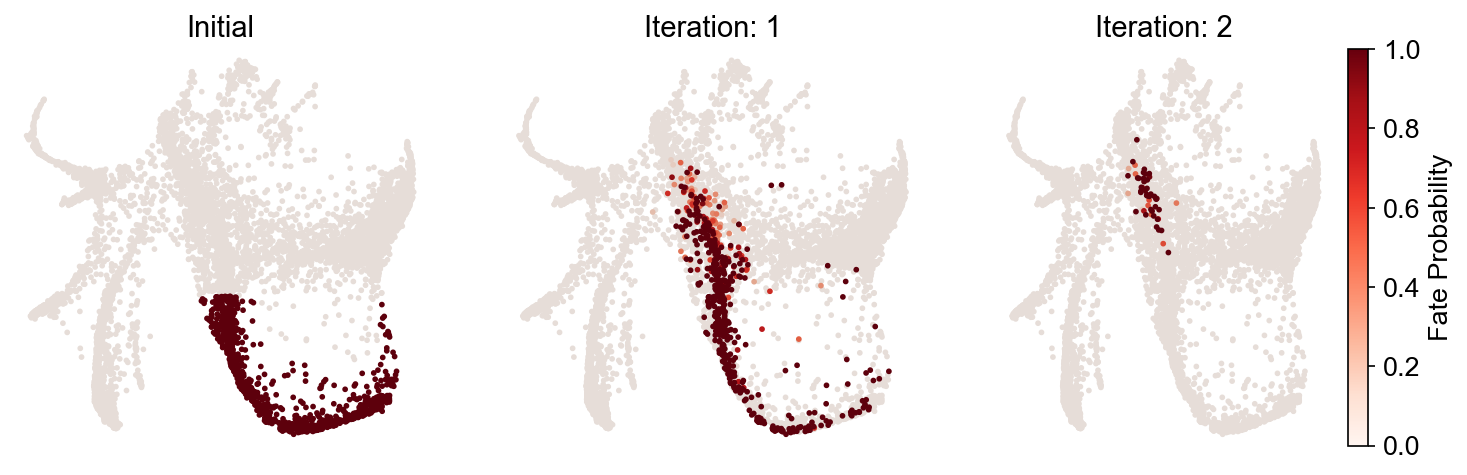

In [29]:
cs.pl.dynamic_trajectory_via_iterative_mapping(adata_5,
        selected_fate='Neutrophil',plot_separately=True,used_Tmap='intraclone_transition_map')

The trajectory can be used for visualizing gene expression dynamics using `cs.pl.gene_expression_dynamics`, as shown above:

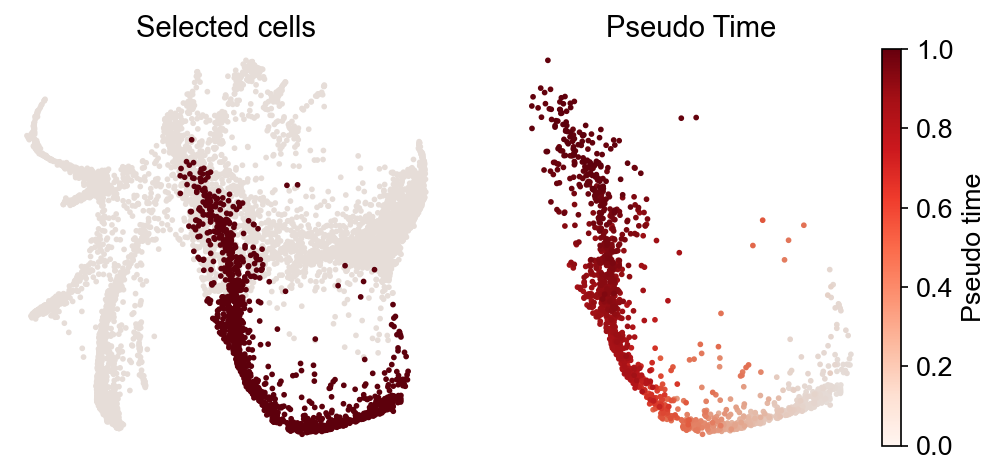

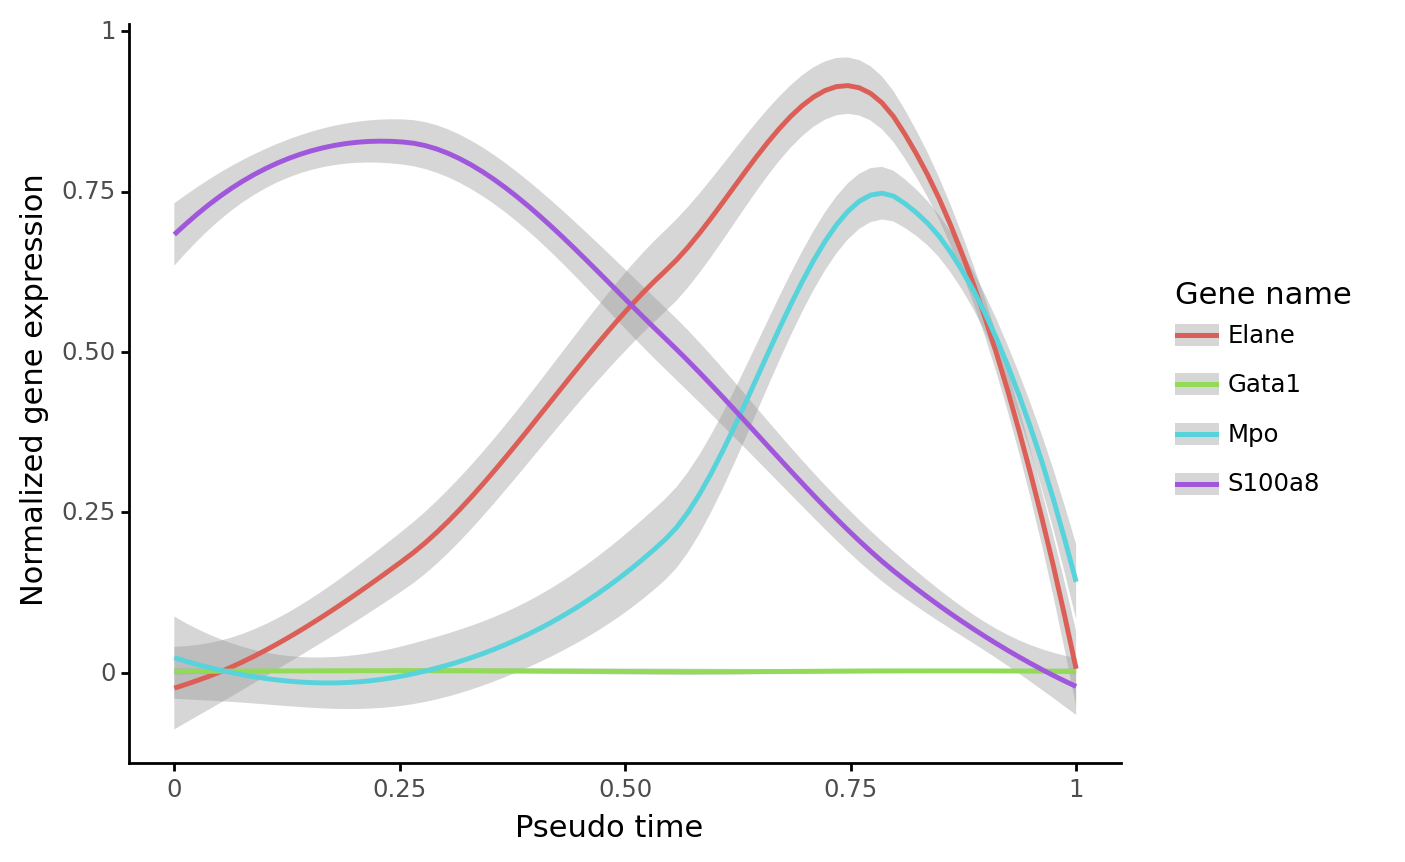

In [30]:
gene_name_list=['Gata1','Mpo', 'Elane', 'S100a8']
selected_fate='Neutrophil'
cs.pl.gene_expression_dynamics(adata_5,selected_fate,gene_name_list, traj_threshold=0.1,  
      invert_PseudoTime=True)